In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
plt.rcParams.update({'font.size': 20})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")
import statistics 

In [2]:
def calibration(y_pre, y0, im, quantiles):

    intervals = []
    for i in range(1, 6):
        intervals.append(quantiles[6] - quantiles[i] )
    a0 = 0
    a1 = 0
    a2 = 0
    a3 = 0
    a4 = 0
    a5 = 0
    a6 = 0
    for i in im:

        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] <=y_pre[i, 1]):
                   a1 += 1
        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] <= y_pre[i, 2]):
                   a2 += 1               
        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] <= y_pre[i, 3]):
                   a3 += 1
        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] < y_pre[i, 4]):
                   a4 += 1
        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] < y_pre[i, 5]):
                   a5 += 1
        if np.logical_and(y0[i] > y_pre[i, 0] ,  y0[i] < y_pre[i, 6]):
                   a6 += 1


    return a1, a2, a3, a4, a5,a6, intervals            
def nash_sutcliffe(y_pre, y0):
    num = np.sum(y0 - y_pre)**2
    den = np.sum(y0 - np.mean(y0))**2
    return 1 - (num/den)

## INPUT PARAMETERS 

In [3]:
depth     = 4
width     = 128
quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])
batchSize = 128

target = 'I2V'


inChannels = np.array(['I1V', 'I2V', 'I3V', 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
#inChannels = np.array(['I1V', 'I2V', 'I3V', 'MWI-15', 'MWI-16', 'I5V', 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])
#inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
i183, = np.argwhere(inChannels == target)[0]

## Read TEST data

In [4]:
from ici import iciData

data = iciData("TB_ICI_test.nc", 
               inChannels, target, 
               batch_size = batchSize)  

x_noise = data.add_noise(data.x, data.index)


## Load the QRNN model for target

In [5]:
file = 'qrnn_ici_%s_%s_%s.nc'%(depth, width, target)
print (file)
qrnn = QRNN.load(file)

qrnn_ici_4_128_I2V.nc


#### predict the expectation value

In [6]:
y_pre, y_prior, y0, y, y_pos_mean = statistics.predict(data, qrnn, add_noise = True)


binstep = 0.5
bins = np.arange(-20, 15, binstep)
iq = np.argwhere(quantiles == 0.5)[0,0]

[0, 1, 2, 5, 6, 7, 8, 9, 10, 11]


In [7]:
hist_noise  = statistics.calculate_pdf(y, y0, bins)

hist_pre    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

hist_prior  = statistics.calculate_pdf(y_prior[:, i183], y0, bins)

hist_pos_mean    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
hist_pos_mean_5  = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 10.0
hist_pos_mean_10 = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
hist_pos_mean_15 = statistics.calculate_pdf(y_pre[:, iq], y0, bins, im)




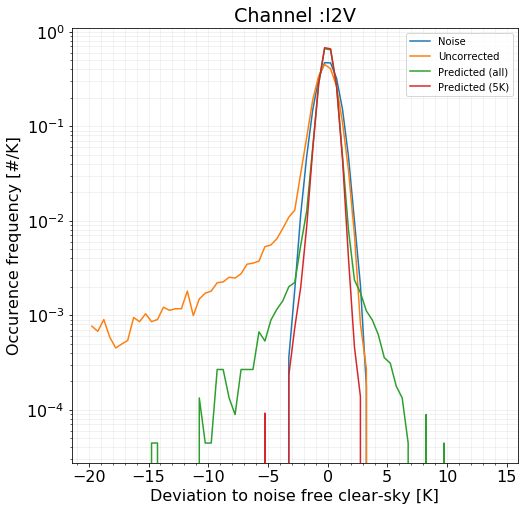

In [8]:
fig, ax = plt.subplots(1,1, figsize = [8,8])

center = (bins[:-1] + bins[1:]) / 2

ax.plot(center, hist_noise[0])
ax.plot(center, hist_prior[0])
ax.plot(center, hist_pre[0])
#ax.plot(center, hist_pos_mean[0])
ax.plot(center, hist_pos_mean_5[0])
#ax.plot(center, hist_pos_mean_10[0])
#ax.plot(center, hist_pos_mean_15[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.2)


ax.legend(["Noise", "Uncorrected", "Predicted (all)", "Predicted (5K)", "Predicted(15K)" ], prop={'size': 10})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/ICI_%s'%str(target))


In [9]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)

\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &    0.00 &         -1.04 &           -0.04 &                -0.02 \\
 mae      &    0.64 &          1.52 &            0.46 &                 0.42 \\
 std      &    0.80 &          5.95 &            0.70 &                 0.53 \\
 skewness &   -0.01 &        -10.79 &           -2.10 &                -0.22 \\
 rejected &    0.00 &          0.00 &            0.00 &                 3.66 \\
\hline
\end{tabular}


In [10]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)

\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &    0.00 &         -1.04 &           -0.04 &                -0.03 \\
 mae      &    0.64 &          1.52 &            0.46 &                 0.43 \\
 std      &    0.80 &          5.95 &            0.70 &                 0.57 \\
 skewness &   -0.01 &        -10.79 &           -2.10 &                -0.60 \\
 rejected &    0.00 &          0.00 &            0.00 &                 1.61 \\
\hline
\end{tabular}


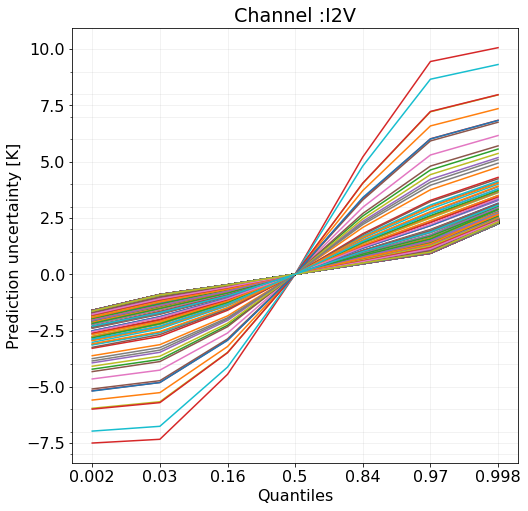

In [11]:
statistics.uncertainty(y_pre, target, 'uncertainty')

In [12]:
#statistics.scatter_error_uncertainty(y_pre, y0, target, 'scatter_uncertainty')

print ('nash sutcliffe', nash_sutcliffe(y_pre[:, iq], y0))

nash sutcliffe -3217470.091757744


43282


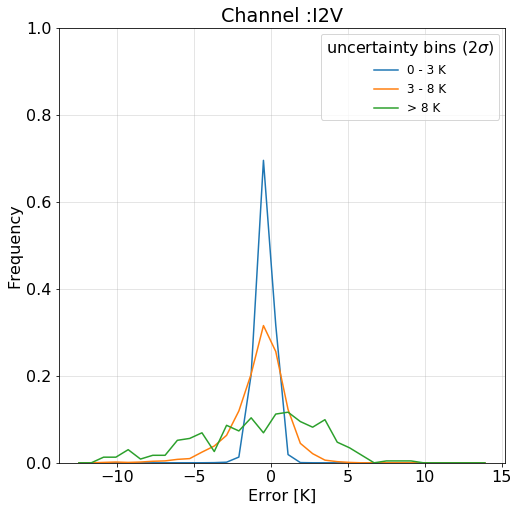

In [13]:
dtb =(y_pre[:, 3] - y0)
uncertain = y_pre[:, 5] - y_pre[:, 1]
ulim = [3, 8] #I1V
#ulim = [3, 4] #I2V
#ulim = [1, 1.5 ]#I3V

im = uncertain < ulim[0]
print (np.sum(im))
bins = np.arange(-12.5, 15., 0.8)
hist = np.histogram(dtb[im], bins, density = True)
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(bins[:-1], hist[0])


im = np.logical_and((uncertain < ulim[1]), ( uncertain >= ulim[0]) )
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])

im = uncertain >=ulim[1]
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Error [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.4)

ax.set_ylim(0, 1)

ax.legend([  '0 - ' + str(ulim[0]) + ' K',
            str(ulim[0]) +' - ' + str(ulim[1]) + ' K',
             '> ' + str(ulim[1]) + ' K' ], title = "uncertainty bins (2$\sigma$)", prop={'size': 12})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/Frequency_uncertainty_bins_%s'%str(target))

In [14]:
### calibration plots

Text(0, 0.5, 'Observed frequency')

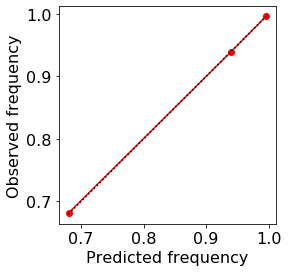

In [15]:
from torch.utils.data import DataLoader, random_split
n = len(data)
n_train = int(0.01 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")

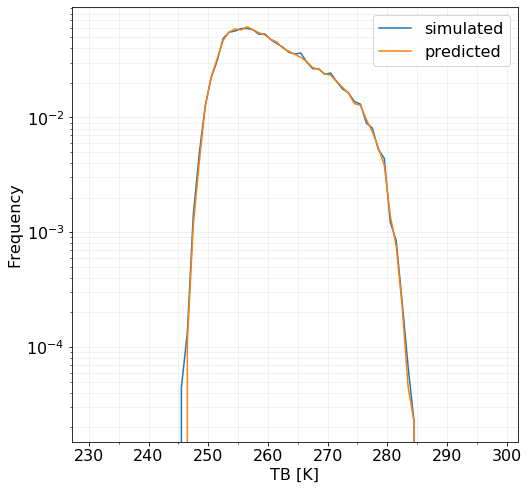

In [16]:
bins = np.arange(230, 300, 1)
h0 = np.histogram(y0, bins, density = True)
h_p = np.histogram(y_pre[:, iq], bins, density = True)
center = (bins[:-1] + bins[1:])/2
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(center, h0[0])
ax.plot(center, h_p[0])
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('TB [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)
ax.legend(["simulated", "predicted"])
fig.savefig('Figures/PDF_%s'%target)

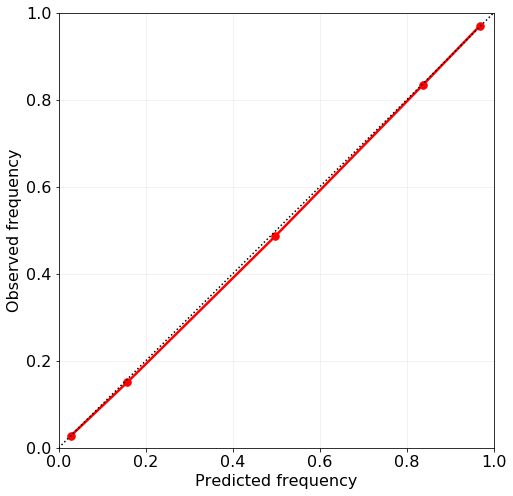

In [17]:
im = np.where(np.abs(y_pre[:, iq] - y_prior[:, i183]) < 5 )[0]
a1, a2, a3, a4, a5, a6, intervals  = calibration(y_pre, y0, im, quantiles)
#im = np.where(np.abs(y_pre[:, iq] - y_prior[:, i183]) < 5 )[0]


fig, ax = plt.subplots(1, 1, figsize = [8,8])        

(ax.plot(intervals[::-1], [ a1/len(y0[im]), a2/len(y0[im]), a3/len(y0[im]), a4/len(y0[im]), a5/len(y0[im]),
                          ], 'r.-', ms = 15, linewidth = 2.5))

#(ax.plot([0.68, 0.94, 0.996], [ a3/len(y0[im]), a2/len(y0[im]), a1/len(y0[im])
#                          ], 'r.-', ms = 15, linewidth = 2.5))

x = np.arange(0,1.2,0.2)
y = x
ax.plot(x, y, 'k:', linewidth = 1.5)
ax.set(xlim = [0, 1], ylim = [0,1])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(which = 'both', alpha = 0.2)
fig.savefig('Figures/calibration_plot_%s'%target)

In [18]:
y_pre_all = y_pre[:,:]

## Load QRNN using only single 183 GHz channel

In [19]:
inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
#i183, = np.argwhere(inChannels == target)[0]

data = iciData("TB_ICI_test.nc", 
               inChannels, target, 
               batch_size = batchSize)  

x_noise = data.add_noise(data.x, data.index)




In [20]:
file = 'qrnn_ici_%s_%s_%s_single.nc'%(depth, width, target)
print (file)
qrnn = QRNN.load(file)
y_pre, y_prior1, y01, y, y_pos_mean1 = statistics.predict(data, qrnn, add_noise = True)


binstep = 0.5
bins = np.arange(-20, 15, binstep)
iq = np.argwhere(quantiles == 0.5)[0,0]

hist_noise  = statistics.calculate_pdf(y, y0, bins)

hist_pre    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

hist_prior  = statistics.calculate_pdf(y_prior[:, i183], y0, bins)

hist_pos_mean    = statistics.calculate_pdf(y_pre[:, iq], y0, bins)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
hist_pos_mean_5  = statistics.calculate_pdf(y_pos_mean, y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 10.0
hist_pos_mean_10 = statistics.calculate_pdf(y_pos_mean, y0, bins, im)

im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
hist_pos_mean_15 = statistics.calculate_pdf(y_pos_mean, y0, bins, im)





qrnn_ici_4_128_I2V_single.nc
[1, 5, 6, 7, 8, 9, 10, 11]


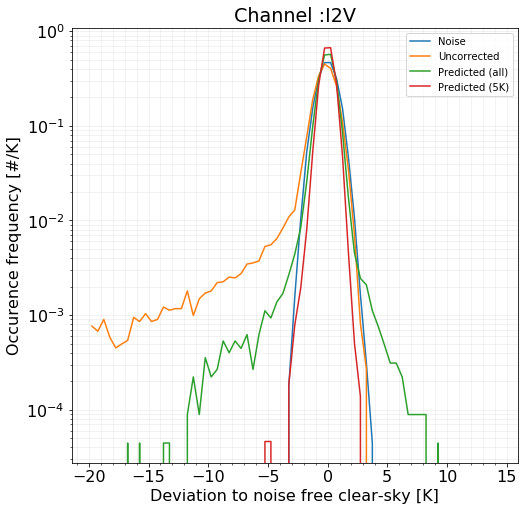

In [21]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
center = (bins[:-1] + bins[1:]) / 2
ax.plot(center, hist_noise[0])
ax.plot(center, hist_prior[0])
ax.plot(center, hist_pre[0])
#ax.plot(center, hist_pos_mean[0])
ax.plot(center, hist_pos_mean_5[0])
#ax.plot(center, hist_pos_mean_10[0])
#ax.plot(center, hist_pos_mean_15[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.2)


ax.legend(["Noise", "Uncorrected", "Predicted (all)", "Predicted (5K)", "Predicted(15K)" ], prop={'size': 10})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/ICI_%s_single'%str(target))


In [22]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 5.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)



\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &   -0.01 &         -1.04 &           -0.05 &                -0.02 \\
 mae      &    0.64 &          1.52 &            0.57 &                 0.50 \\
 std      &    0.80 &          5.95 &            0.86 &                 0.64 \\
 skewness &    0.00 &        -10.79 &           -2.51 &                -0.22 \\
 rejected &    0.00 &          0.00 &            0.00 &                 3.66 \\
\hline
\end{tabular}


In [23]:
im = np.abs(y_pos_mean - y_prior[:, i183]) <= 15.0
statistics.calculate_statistics_T(y_prior, y0, y, y_pre[:, 3], im, i183)

\begin{tabular}{lrrrr}
\hline
          &   noise &   uncorrected &   corrected\_all &   corrected\_filtered \\
\hline
 bias     &   -0.01 &         -1.04 &           -0.05 &                -0.03 \\
 mae      &    0.64 &          1.52 &            0.57 &                 0.52 \\
 std      &    0.80 &          5.95 &            0.86 &                 0.69 \\
 skewness &    0.00 &        -10.79 &           -2.51 &                -0.52 \\
 rejected &    0.00 &          0.00 &            0.00 &                 1.61 \\
\hline
\end{tabular}


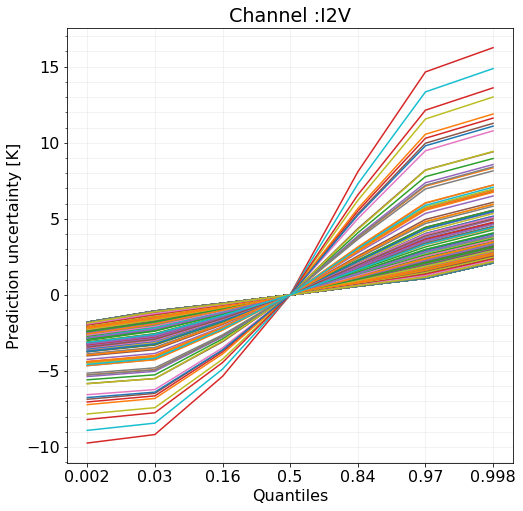

In [24]:
statistics.uncertainty(y_pre, target, 'uncertainty_single')


41258


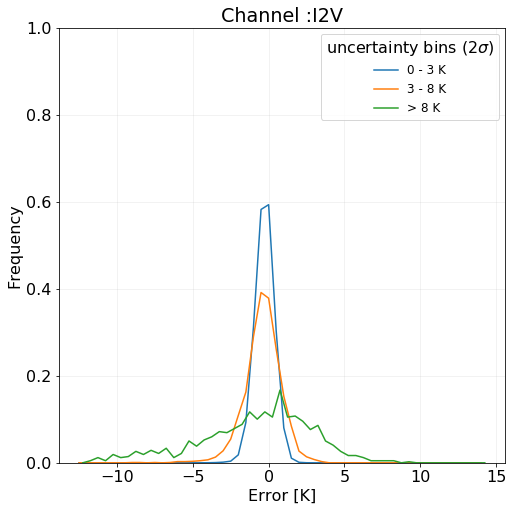

In [25]:
dtb =(y_pre[:, 3] - y0)
uncertainty = y_pre[:, 5] - y_pre[:, 1]
ulim = [3, 8] #I1V
#ulim = [3, 4] #I2V
#ulim = [1, 1.5 ]#I3V

im = uncertainty < ulim[0]
print (np.sum(im))
bins = np.arange(-12.5, 15., 0.5)
hist = np.histogram(dtb[im], bins, density = True)
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(bins[:-1], hist[0])


im = np.logical_and((uncertainty < ulim[1]), ( uncertainty >= ulim[0]) )
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])

im = uncertainty >=ulim[1]
hist = np.histogram(dtb[im], bins, density = True)

center = (bins[:-1] + bins[1:])/2
ax.plot(center, hist[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Error [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)

ax.set_ylim(0, 1)

ax.legend([  '0 - ' + str(ulim[0]) + ' K',
            str(ulim[0]) +' - ' + str(ulim[1]) + ' K',
             '> ' + str(ulim[1]) + ' K' ], title = "uncertainty bins (2$\sigma$)", prop={'size': 12})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/Frequency_uncertainty_bins_%s_single'%str(target))

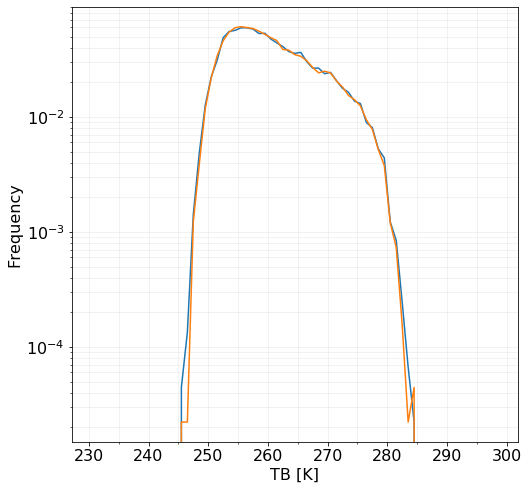

In [26]:
bins = np.arange(230, 300, 1)
h0 = np.histogram(y0, bins, density = True)
h_p = np.histogram(y_pre[:, iq], bins, density = True)
center = (bins[:-1] + bins[1:])/2
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(center, h0[0])
ax.plot(center, h_p[0])
ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('TB [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)
fig.savefig('Figures/PDF_%s_single'%target)

/home/inderpreet/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


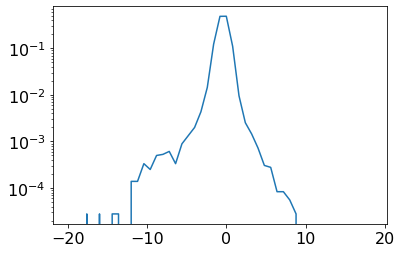

In [27]:
fig, ax = plt.subplots(1, 1)
bins = np.arange(-20, 20, 0.8)
hist = np.histogram(dtb[data.surface>0], bins, density = True)
ax.plot(bins[:-1], hist[0] )

hist = np.histogram(dtb[data.surface<1], bins, density = True)
ax.plot(bins[:-1], hist[0] )
ax.set_yscale('log')

In [28]:
from torch.utils.data import DataLoader, random_split
n = len(data)
n_train = int(0.01 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])

Text(0, 0.5, 'Observed frequency')

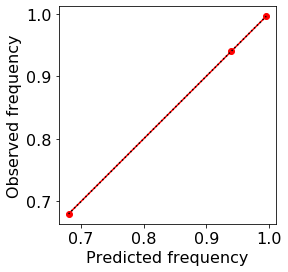

In [29]:
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")


In [30]:
dtb = y_pre[:, iq] - y0


In [31]:
i183

1

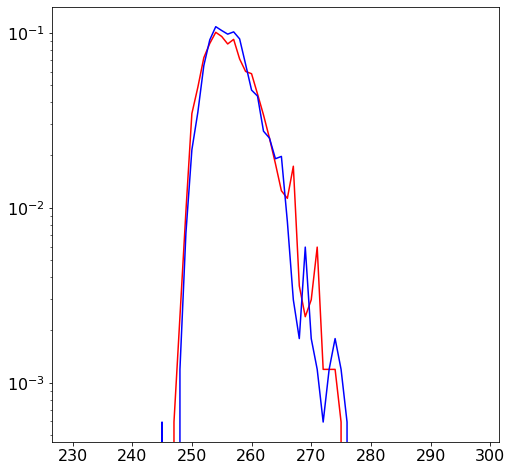

In [32]:
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) > 5.0 
d = y_pre_all[:, iq] - y_pre[:, iq]

bins = np.arange(230, 300, 1)

hist = np.histogram( y_pre_all[im, iq], bins, density = True)

fig, ax = plt.subplots(1, 1, figsize = [8, 8])

ax.plot(bins[:-1], hist[0], 'r')
ax.set_yscale('log')

hist = np.histogram( y_pre[im, iq], bins, density = True)
ax.plot(bins[:-1], hist[0], 'b')

ax.set_yscale('log')

(240, 300)

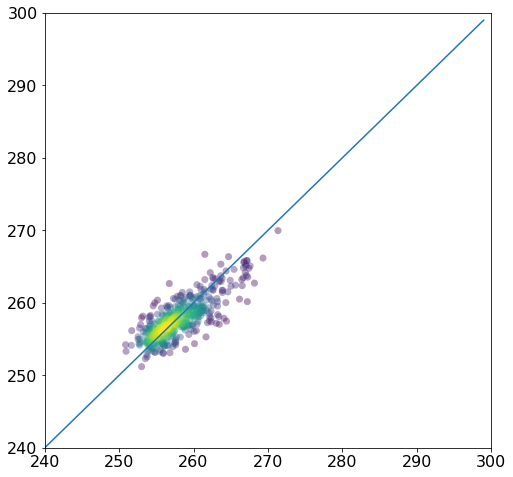

In [33]:
from statistics import density
fig, ax = plt.subplots(1,1, figsize = [8, 8])
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) > 25.0 

x, y, z = density(y_pre_all[im, iq], y_pre[im, iq])
ax.scatter(x, y, c=z, s=50, edgecolor='', alpha = 0.4)

xx = np.arange(230, 300, 1)
yy = xx
ax.plot(xx, yy)
ax.set_xlim(240, 300)
ax.set_ylim(240, 300)

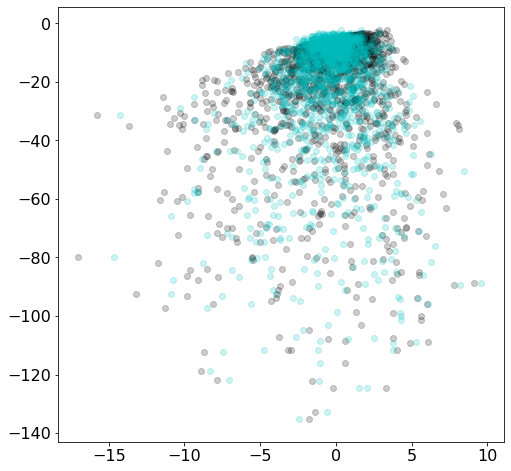

In [34]:
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) > 5.0 
fig, ax = plt.subplots(1, 1, figsize = [8,8])




ax.scatter(y_pre[im, iq]- y0[im] , y_prior[im, i183] - y0[im], alpha = 0.2, color = 'k' )
ax.scatter(y_pre_all[im, iq] - y0[im], y_prior[im, i183]- y0[im], alpha = 0.2, color = 'c')

#ax.scatter(y_pre_all[im, 5] - y_pre_all[im, 3], y_pre[im, 5] - y_pre[im, 3]  )
xx = np.arange(100, 300)
yy = xx
#ax.plot(xx, yy, 'r')



41258


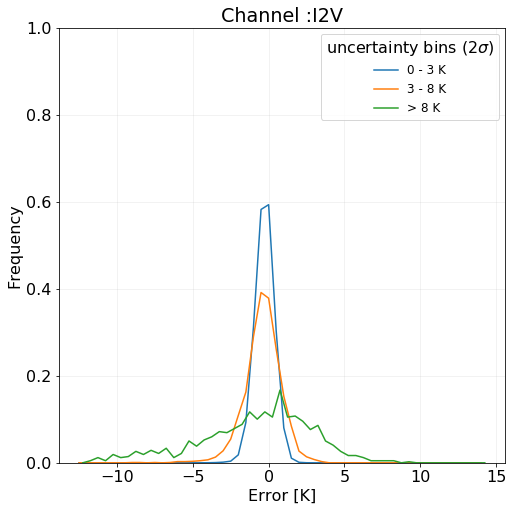

In [35]:
dtb =(y_pre[:, 3] - y0)
cloud = y_prior[:, i183]
ulim = [3, 8] #I1V
#ulim = [3, 4] #I2V
#ulim = [1, 1.5 ]#I3V

im = uncertainty < ulim[0]
print (np.sum(im))
bins = np.arange(-12.5, 15., 0.5)
hist = np.histogram(dtb[im], bins, density = True)
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(bins[:-1], hist[0])


im = np.logical_and((uncertainty < ulim[1]), ( uncertainty >= ulim[0]) )
hist = np.histogram(dtb[im], bins, density = True)

ax.plot(bins[:-1], hist[0])

im = uncertainty >=ulim[1]
hist = np.histogram(dtb[im], bins, density = True)

center = (bins[:-1] + bins[1:])/2
ax.plot(center, hist[0])
ax.set_ylabel('Frequency')
ax.set_xlabel('Error [K]')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha = 0.2)

ax.set_ylim(0, 1)

ax.legend([  '0 - ' + str(ulim[0]) + ' K',
            str(ulim[0]) +' - ' + str(ulim[1]) + ' K',
             '> ' + str(ulim[1]) + ' K' ], title = "uncertainty bins (2$\sigma$)", prop={'size': 12})

ax.set_title("Channel :%s"%target)

fig.savefig('Figures/Frequency_uncertainty_bins_%s_single'%str(target))

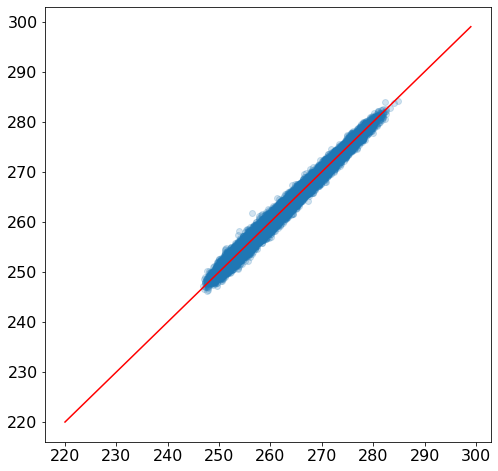

In [36]:
im = np.abs(y_pre[:, iq] - y_prior[:, i183]) < 5.0 
fig, ax = plt.subplots(1, 1, figsize = [8,8])
#ax.scatter(y_prior[im, 0], y_prior[im, i183] - y0[im], alpha = 0.2)
#ax.scatter(y_prior[im, 1], y_prior[im, i183] - y0[im], alpha = 0.2)
ax.scatter(y_pre[im, iq], y_pre_all[im, iq], alpha = 0.2)
#ax.scatter(y_prior[im, 2], y_prior[im, i183] - y0[im], alpha = 0.2)
#ax.scatter(y_prior[im, 2], y_prior[im, i183] - y0[im], alpha = 0.2)
xx = np.arange(220, 300)
yy = xx
ax.plot(xx, yy, 'r')

0 -1 0.002 0.998
1 -2 0.03 0.97
2 -3 0.16 0.84


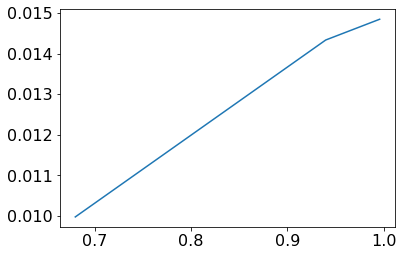

In [37]:
im = np.argwhere(np.abs(y_pre[:, iq] - y_prior[:, i183]) > 15.0 )
n_intervals = quantiles.size // 2
qs = quantiles
intervals = np.array([q_r - q_l for (q_l, q_r)
                      in zip(qs, reversed(qs))])[:n_intervals]
counts = np.zeros(n_intervals)

total = 0.0

for i in range(n_intervals):
    print (i, -(i+1), quantiles[i], quantiles[-(i+1)])
    l = y_pre[im, [i]]
    r = y_pre[im, [-(i + 1)]]
    counts[i] += np.logical_and(y0[im] >= l, y0[im] < r).sum()

#total += np.prod(y.size())

#return intervals[::-1], (counts / total)[::-1]

plt.plot(intervals[::-1], (counts / len(y0[:]))[::-1])



In [38]:
intervals

array([0.996, 0.94 , 0.68 ])

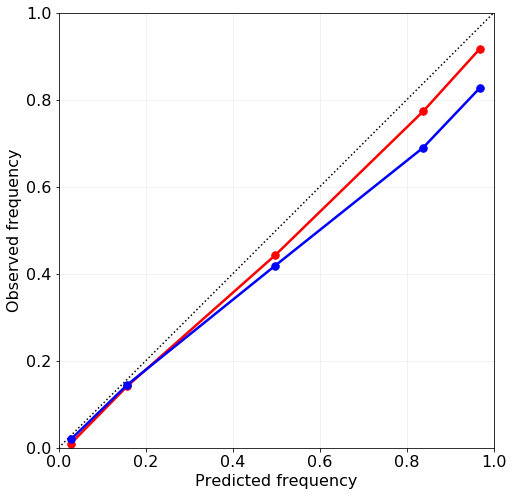

In [39]:
im = np.where(np.abs(y_pre[:, iq] - y_prior[:, i183]) > 15 )[0]
a1, a2, a3, a4, a5, a6, intervals  = calibration(y_pre, y0, im, quantiles)
#im = np.where(np.abs(y_pre[:, iq] - y_prior[:, i183]) < 5 )[0]


fig, ax = plt.subplots(1, 1, figsize = [8,8])        

(ax.plot(intervals[::-1], [ a1/len(y0[im]), a2/len(y0[im]), a3/len(y0[im]), a4/len(y0[im]), a5/len(y0[im]),
                          ], 'r.-', ms = 15, linewidth = 2.5))

#(ax.plot([0.68, 0.94, 0.996], [ a3/len(y0[im]), a2/len(y0[im]), a1/len(y0[im])
#                          ], 'r.-', ms = 15, linewidth = 2.5))

x = np.arange(0,1.2,0.2)
y = x
ax.plot(x, y, 'k:', linewidth = 1.5)
ax.set(xlim = [0, 1], ylim = [0,1])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(which = 'both', alpha = 0.2)
fig.savefig('Figures/calibration_plot_%s'%target)

im = np.where(np.abs(y_pre_all[:, iq] - y_prior[:, i183]) > 15 )[0]
a1, a2, a3, a4, a5, a6, intervals  = calibration(y_pre_all, y0, im, quantiles)

#(ax.plot([0.68,0.94, 0.996], [ a3/len(y0[im]), a2/len(y0[im]), a1/len(y0[im])
#                          ], 'b.-', ms = 15, linewidth = 2.5))

(ax.plot(intervals[::-1], [ a1/len(y0[im]), a2/len(y0[im]), a3/len(y0[im]), a4/len(y0[im]), a5/len(y0[im]),
                           ], 'b.-', ms = 15, linewidth = 2.5))

In [40]:
dBZ = np.load('dbz_test.npy', allow_pickle = True)
alt = np.load('alt_test.npy', allow_pickle = True)


In [41]:
A = []
D = []
E = []
for i in range(45000):
    idbz = np.array((np.array(dBZ[i]) > -30.0))
    a = np.array(alt[i])
    d = np.array(dBZ[i])
    n = np.sum(idbz)
    e = np.repeat(dtb[i], n)
    A.append(a[idbz])
    D.append(d[idbz])
    E.append(e)

In [42]:
ind = []
binstep = 400
bins = np.arange(0, 19000, binstep)
nbins = 19000//binstep +1
for i in range(45000):
    alt = A[i]
    ind.append(np.digitize(alt, bins))
    

In [43]:
nbins

48

In [44]:
ee = [[] for i in range(nbins)]
dd = [[] for i in range(nbins)]
for i in range(45000):

    if len(E[i]) > 0:
        e = E[i]
        d = D[i]
        for j in range(nbins):
            ix = np.where(ind[i] == j)[0]

            if ix.size > 0:
#                print (ix)
                dd[j].append(d[ix])
                ee[j].append(e[ix])

Text(0, 0.5, 'altitude [m]')

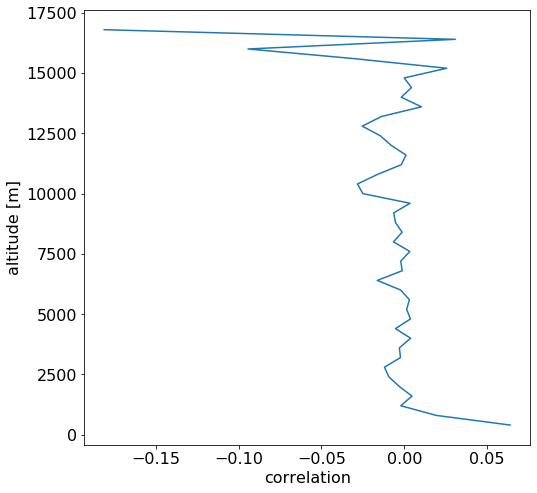

In [45]:
corr = []
altitude = []
for i in range(nbins):
    if len(dd[i]) > 10:
#        print(len(dd[i]))
        d = np.concatenate(dd[i])
        e = np.concatenate(ee[i])
        corr.append(np.corrcoef(e, d)[0, 1])
        altitude.append(bins[i])
fig, ax = plt.subplots(1, 1, figsize = [8,8])
ax.plot(corr, altitude)
ax.set_xlabel('correlation')
ax.set_ylabel('altitude [m]')

        


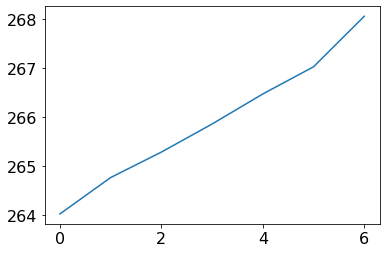

In [46]:
plt.plot(y_pre[1000, :])